In [1]:
import imageio
import torch
from IPython.display import clear_output
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PyQt5
%matplotlib inline


In [2]:
frame_sample_rate = 10
videosList=[]
for vidIdx in range(7):
    vidCv2 = cv2.VideoCapture(f'data/usliverseq-mp4/volunteer{str(vidIdx+1).zfill(2)}.mp4')
    frameIdx = 0
    frames = []
    while(vidCv2.isOpened()):
        ret, frame = vidCv2.read()
        if ret == True and frameIdx % frame_sample_rate == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)
        if ret == False:
            break
        frameIdx+=1

    #number of frames in video:
    print(f'volunteer{str(vidIdx+1).zfill(2)}.mp4:\n')
    print("number of frames:" ,int(vidCv2.get(cv2.CAP_PROP_FRAME_COUNT)))
    #frame size:
    print("frame size:" ,int(vidCv2.get(cv2.CAP_PROP_FRAME_WIDTH)), "x", int(vidCv2.get(cv2.CAP_PROP_FRAME_HEIGHT)),'\n')

    
    video = np.stack(frames, axis=0)
    videosList.append(video)

    cv2.destroyAllWindows()
    

volunteer01.mp4:

number of frames: 14516
frame size: 640 x 480 

volunteer02.mp4:

number of frames: 4372
frame size: 712 x 480 

volunteer03.mp4:

number of frames: 4625
frame size: 700 x 480 

volunteer04.mp4:

number of frames: 4078
frame size: 720 x 540 

volunteer05.mp4:

number of frames: 3983
frame size: 720 x 540 

volunteer06.mp4:

number of frames: 4943
frame size: 672 x 480 

volunteer07.mp4:

number of frames: 4593
frame size: 500 x 480 



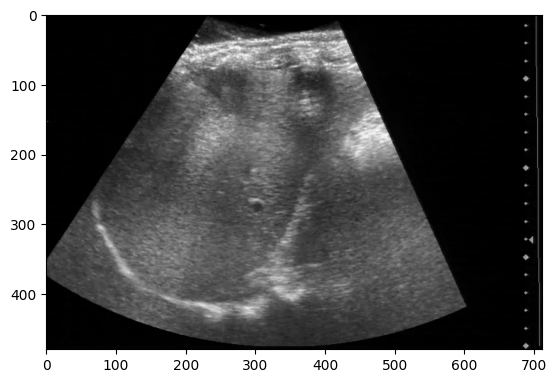

In [4]:
videoIdx = 1 # Choose video to visualize
noFrames = 100 # Choose first noFrames to visualize

vidShow=videosList[videoIdx][:noFrames]
for i in range(noFrames):
    plt.imshow(vidShow[i],cmap='gray')
    plt.show()
    clear_output(wait=True)

In [24]:
def simTrans(p,q):
  """SIMTRANS computes the similarity transformation parameters from x to y
  where x and y is N-by-2 arrays of points in two different
  imaging modalities"""

  # Compute centered landmark sets
  pC = p-p.mean(axis=1)[:,None]
  qC = q-q.mean(axis=1)[:,None]



  num=np.sum(np.sqrt(np.sum(qC**2,axis=0)))
  denom=np.sum(np.sqrt(np.sum(pC**2,axis=0)))

  s_hat=num/denom
 
    
  C = qC @ pC.T
  U,_,V=np.linalg.svd(C)
  
  R_hat = U @ np.array([[1,0],[0,np.linalg.det(U @ V.T)]]) @ V.T
  
  t_hat = q.mean(axis=1)[:,None]-s_hat*R_hat @ p.mean(axis=1)[:,None]; 

  return R_hat,s_hat,t_hat.squeeze()

In [27]:
# Switch to interactive mode
%matplotlib qt 

In [28]:
ptsList=[]
for vidIdx in range(7):
    plt.imshow(videosList[vidIdx][0]>10,cmap='gray')
    pts=plt.ginput(4)
    ptsList.append(np.array(pts))
    plt.show()
    plt.close()
ptsArray = np.array(ptsList)

In [29]:
# Switch back to inline mode
%matplotlib inline 

### Below not working! We need to do a full affine transformation and not just similarity transformation

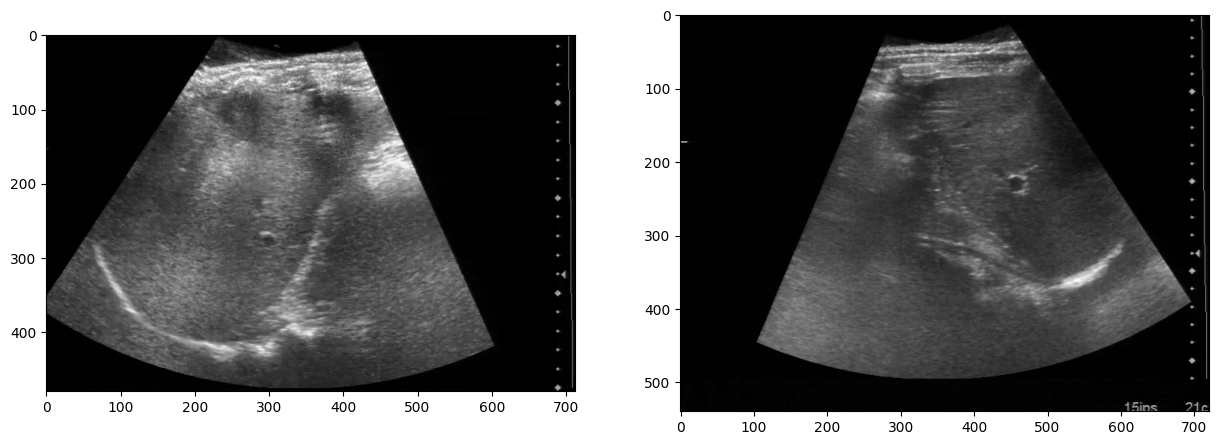

In [30]:
ref=1
temp=3

# I will try to transform from video 2 to 1
# Visualize the first frame of each video
fig,ax=plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(videosList[ref][0],cmap='gray')
ax[1].imshow(videosList[temp][0],cmap='gray')

In [31]:
# Get transformation parameters for the two videos
R_hat,s_hat,t_hat = simTrans(ptsArray[ref].T,ptsArray[temp].T)

from scipy.ndimage import affine_transform
def affine_transform_fn(input_array, R_hat,s_hat,t_hat,output_shape):
    output_array = affine_transform(
        input_array,
        s_hat*R_hat,
        offset=t_hat,
        output_shape=output_shape,
        order=1,
        mode='constant',
        cval=0.0,
        prefilter=True
    )
    return output_array


In [34]:
transformed_image = affine_transform_fn(videosList[ref][0], R_hat,s_hat,t_hat,videosList[temp][0].shape)

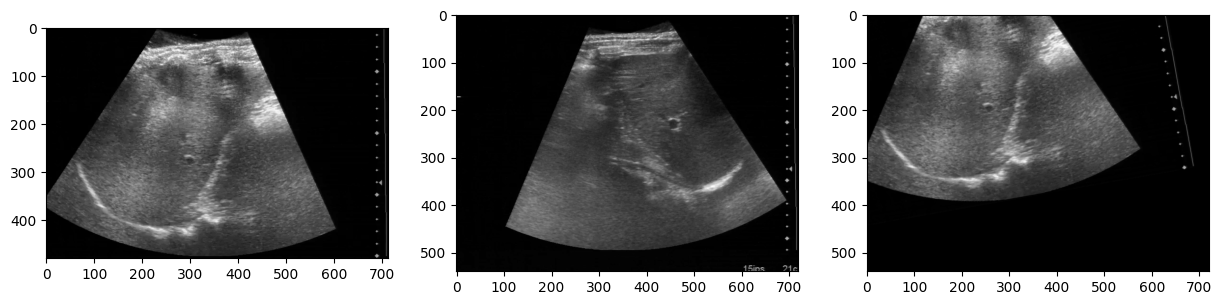

In [35]:
# I will try to transform from video 2 to 1
# Visualize the first frame of each video
fig,ax=plt.subplots(1,3,figsize=(15,8))
ax[0].imshow(videosList[ref][0],cmap='gray')
ax[1].imshow(videosList[temp][0],cmap='gray')
ax[2].imshow(transformed_image,cmap='gray')

In [36]:
t_hat

array([34.11341219, 77.63987846])

In [37]:
R_hat

array([[ 0.98458122,  0.17492807],
       [-0.17492807,  0.98458122]])

In [38]:
s_hat

1.0162157111356944